In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GroupShuffleSplit, cross_validate, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

Here we import the data and add a `correctness` variable that is equal to `1` if ground truth and the answer option are equal.

In [2]:
df = pd.read_csv('../../data/answerList_data.csv')
df['correctness'] = (((df['GroundTruth'] == 0.0) & (df['Answer.option'] == 'NO')) | ((df['GroundTruth'] == 1.0) & (df['Answer.option'] == 'YES'))).astype(int)

df

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.ID,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness
0,261,HIT01_8,0,90.984,4,2,0,0,1,0,...,832cg-7G1i-462:73eI-8E-2g-985,5,Undergraduate_Student,7.0,21,Male,High School,United States,Java; C++; C#,1
1,262,HIT01_8,0,133.711,5,1,0,0,1,0,...,98ce7A-4i-507,4,Undergraduate_Student,10.0,25,Female,High School;University;Web,United States,c#,1
2,263,HIT01_8,0,77.696,5,2,0,0,1,0,...,881AC0I2E-625:135cI3E-7e8-86,5,Professional_Developer,7.0,24,Male,High School;University;Web,United States,C++;Java;PHP,1
3,264,HIT01_8,0,46.644,1,1,0,0,1,0,...,270eG-5c6A3-46:65eI-2i-2I-9-36,5,Professional_Developer,20.0,38,Male,High School;University;Other On the job,USA,C#,1
4,265,HIT01_8,0,215.416,5,5,0,0,1,0,...,844Cg1g5e1-17:255ei-8G8E85-8,3,Undergraduate_Student,5.0,19,Male,High School;University;Web,United States,C++; Java,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2316,HIT08_54,128,220.420,2,4,0,0,1,0,...,1171ea-4g-6C-73-8,3,Graduate_Student,2.0,28,Male,University,USA,C#,1
2576,2317,HIT08_54,128,322.790,4,3,0,0,0,0,...,66AC-5a0g-47-9:1443IA-7C-6e967,5,Professional_Developer,17.0,39,Male,University;Web,USA,C#; VB.NET; Java,0
2577,2318,HIT08_54,128,159.530,5,1,0,0,1,0,...,106iG8G-9I-9-80:590CG-6G-7i-71-9,4,Professional_Developer,10.0,31,Male,High School;University;Web;Other work,usa,C++,1
2578,2319,HIT08_54,128,68.578,5,1,0,0,1,0,...,1221iC8A5A242:495CC9e6a691:11aE2c-4c-9-86,4,Undergraduate_Student,4.0,19,Male,University;Web;Other FIRST Robotics,United States,C++,1


In [3]:
# We balance the dataset by taking the same number of samples for each class

df_0 = df[df['GroundTruth'] == 0]
df_1 = df[df['GroundTruth'] == 1]

if len(df_0) > len(df_1):
    df_0_balanced = df_0.sample(len(df_1))
    df_balanced = pd.concat([df_0_balanced, df_1])
else:
    df_1_balanced = df_1.sample(len(df_0))
    df_balanced = pd.concat([df_0, df_1_balanced])

df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

df = df_balanced
df.groupby('GroundTruth').size()

GroundTruth
0    500
1    500
dtype: int64

Next we add a column that quantifies the complexity of an explanation. We chose the TTR (typen-token ratio) metric. This calculates a ratio of unique tokens in relation to all. We decided against using the Halstead volume since it is more used for the analysis of software projects. In the end we decided to choose the TTR since it is relatively easy to compute in comparison to other NLP-based metrics, where machine learning is used. Furthermore, TTR is commonly used for estimating lexical diversity which implies greater complexity.

In [4]:
def calculate_ttr(text):
    tokens = text.split()
    unique_tokens = set(tokens)
    ttr = len(unique_tokens) / len(tokens) if tokens else 0
    return ttr

df['TTR'] = df['Answer.explanation'].astype(str).apply(calculate_ttr)
df

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR
0,2351,HIT06_51,92,376.040,2,5,1,1,0,0,...,5,Hobbyist,1.0,24,Female,Web,india,python,1,0.882353
1,342,HIT03_6,19,172.453,4,2,0,0,1,0,...,3,Undergraduate_Student,5.0,19,Male,High School;University;Web,United States,C++; Java,1,0.775510
2,751,HIT04_7,33,27.374,4,4,0,0,1,0,...,3,Professional_Developer,2.0,26,Female,High School;University;Web,USA,java,1,1.000000
3,1439,HIT07_33,104,53.939,5,2,1,1,0,0,...,5,Professional_Developer,10.0,32,Male,University;Web,USA,php,1,0.923077
4,114,HIT02_24,12,57.447,4,2,0,0,1,0,...,5,Professional_Developer,7.0,24,Male,High School;University;Web,United States,C++;Java;PHP,1,0.818182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1905,HIT06_51,84,253.628,0,2,1,0,0,1,...,5,Hobbyist,5.0,36,Male,Web,united states,C++,0,0.920000
996,1241,HIT04_7,65,177.237,3,3,0,0,1,0,...,3,Professional_Developer,4.0,29,Male,Web,united States,Java,1,1.000000
997,1342,HIT04_7,60,599.167,2,4,0,0,1,0,...,4,Other,30.0,50,Male,University;Web,USA,C++,1,0.888889
998,1429,HIT07_33,104,507.941,5,1,1,1,0,0,...,4,Professional_Developer,6.0,29,Female,University;Web,USA,JAVA,1,0.928571


In [5]:
df['Answer.option.int'] = df['Answer.option'].map({'NO': 0, 'IDK': 0.5, 'YES': 1})
df['Worker.gender.int'] = df['Worker.gender'].map({'Male': -1, 'Other': 0, 'Female': 1})
df['Worker.profession.int'] = df['Worker.profession'].map({'Other': 0, 'Hobbyist': 1, 'Undergraduate_Student': 2, 'Graduate_Student': 3, 'Professional_Developer':4})


In [6]:
df_holdout = df[df['FailingMethod'].isin(['HIT01_8', 'HIT02_24'])]
df_train = df[~df['FailingMethod'].isin(['HIT01_8', 'HIT02_24'])]

df_train

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR,Answer.option.int,Worker.gender.int,Worker.profession.int
0,2351,HIT06_51,92,376.040,2,5,1,1,0,0,...,24,Female,Web,india,python,1,0.882353,1.0,1,1
1,342,HIT03_6,19,172.453,4,2,0,0,1,0,...,19,Male,High School;University;Web,United States,C++; Java,1,0.775510,0.0,-1,2
2,751,HIT04_7,33,27.374,4,4,0,0,1,0,...,26,Female,High School;University;Web,USA,java,1,1.000000,0.0,1,4
3,1439,HIT07_33,104,53.939,5,2,1,1,0,0,...,32,Male,University;Web,USA,php,1,0.923077,1.0,-1,4
5,567,HIT03_6,25,91.074,5,1,0,0,0,0,...,35,Male,Web,USA,JAVA; C,0,0.941176,1.0,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1905,HIT06_51,84,253.628,0,2,1,0,0,1,...,36,Male,Web,united states,C++,0,0.920000,0.5,-1,1
996,1241,HIT04_7,65,177.237,3,3,0,0,1,0,...,29,Male,Web,united States,Java,1,1.000000,0.0,-1,4
997,1342,HIT04_7,60,599.167,2,4,0,0,1,0,...,50,Male,University;Web,USA,C++,1,0.888889,0.0,-1,0
998,1429,HIT07_33,104,507.941,5,1,1,1,0,0,...,29,Female,University;Web,USA,JAVA,1,0.928571,1.0,1,4


## First Tree: Decision Tree Classifier

The first approach we were trying out was a decision tree classifier. Since decision trees only accept numerical inputs we had to transform some of the input columns to numerical values. After that we created the train dataset which is used for all further approaches. We also split our data using cross-validation here.

In [24]:
input_cols_full = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.profession', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
input_cols = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
output_col = 'correctness'

X = df_train[input_cols]
y = df_train[output_col]

groups = df_train['FailingMethod'].values
gss = GroupShuffleSplit(n_splits=len(pd.unique(groups)), test_size=1/len(pd.unique(groups)))

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

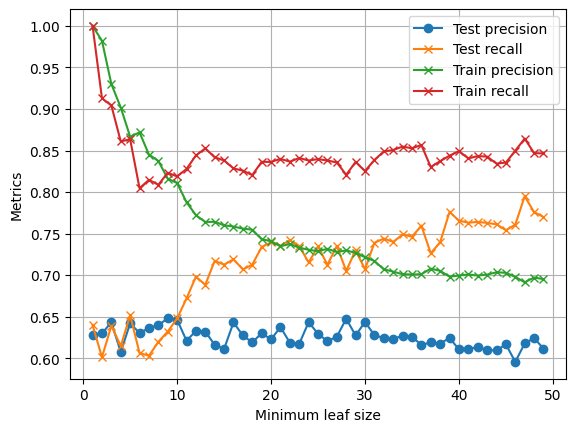

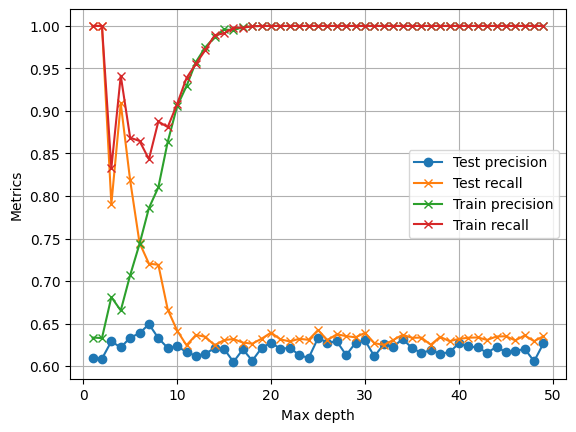

In [25]:
def get_decision_tree_classifier(min_samples_leaf, max_depth, return_model=True, print_metrics=True):
    clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, max_depth=max_depth)

    cv_results = cross_validate(
        clf, X, y, cv=gss, groups=groups,
        scoring=['precision', 'recall'],
        return_estimator=True,
        return_train_score=True
    )
    if print_metrics:
        print("Mean Precision train:", np.mean(cv_results['train_precision']))
        print("Mean Recall train:", np.mean(cv_results['train_recall']))

        print("Precision for each fold:", cv_results['test_precision'])
        print("Mean Precision:", np.mean(cv_results['test_precision']))

        print("Recall for each fold:", cv_results['test_recall'])
        print("Mean Recall:", np.mean(cv_results['test_recall']))

    best_model_idx = np.argmax(cv_results['test_precision'])
    best_model = cv_results['estimator'][best_model_idx]

    if not return_model:
         return np.mean(cv_results['test_precision']), np.mean(cv_results['test_recall']), np.mean(cv_results['train_precision']), np.mean(cv_results['train_recall'])

    return np.mean(cv_results['test_precision']), np.mean(cv_results['test_recall']), np.mean(cv_results['train_precision']), np.mean(cv_results['train_recall']), best_model



max_val = 50
def avg_decision_tree_classifier(leaf_size, depth, runs=10):
    results = [get_decision_tree_classifier(leaf_size, depth, return_model=False, print_metrics=False) for _ in range(runs)]
    avg_result = tuple(sum(values) / runs for values in zip(*results))
    return avg_result

vals_leaf_size = [avg_decision_tree_classifier(leaf_size, 100) for leaf_size in tqdm(range(1, max_val), leave=True)]
vals_depth = [avg_decision_tree_classifier(1, depth) for depth in tqdm(range(1, max_val))]

def plot_diag(vals, x_label):
    y1_vals, y2_vals, y3_vals, y4_vals = zip(*vals)

    plt.plot(range(1, max_val), y1_vals, label='Test precision', marker='o')
    plt.plot(range(1, max_val), y2_vals, label='Test recall', marker='x')
    plt.plot(range(1, max_val), y3_vals, label='Train precision', marker='x')
    plt.plot(range(1, max_val), y4_vals, label='Train recall', marker='x')
    plt.xlabel(x_label)
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_diag(vals_leaf_size, 'Minimum leaf size')
plot_diag(vals_depth, 'Max depth')

We then trained the model and checked for different minimum leaf sizes and maximum depths to get a better understanding, how the model behaves under changes of these parameters. Although we did not check for combinations of these we clearly got an estimate how they influence the models' performance.

Mean Precision train: 0.6998875813241484
Mean Recall train: 0.8426190785557818
Precision for each fold: [0.58947368 0.68333333 0.68333333 0.58947368 0.6125     0.6125    ]
Mean Precision: 0.6284356725146197
Recall for each fold: [0.8115942  0.78095238 0.78095238 0.8115942  0.73134328 0.73134328]
Mean Recall: 0.7746299558110071


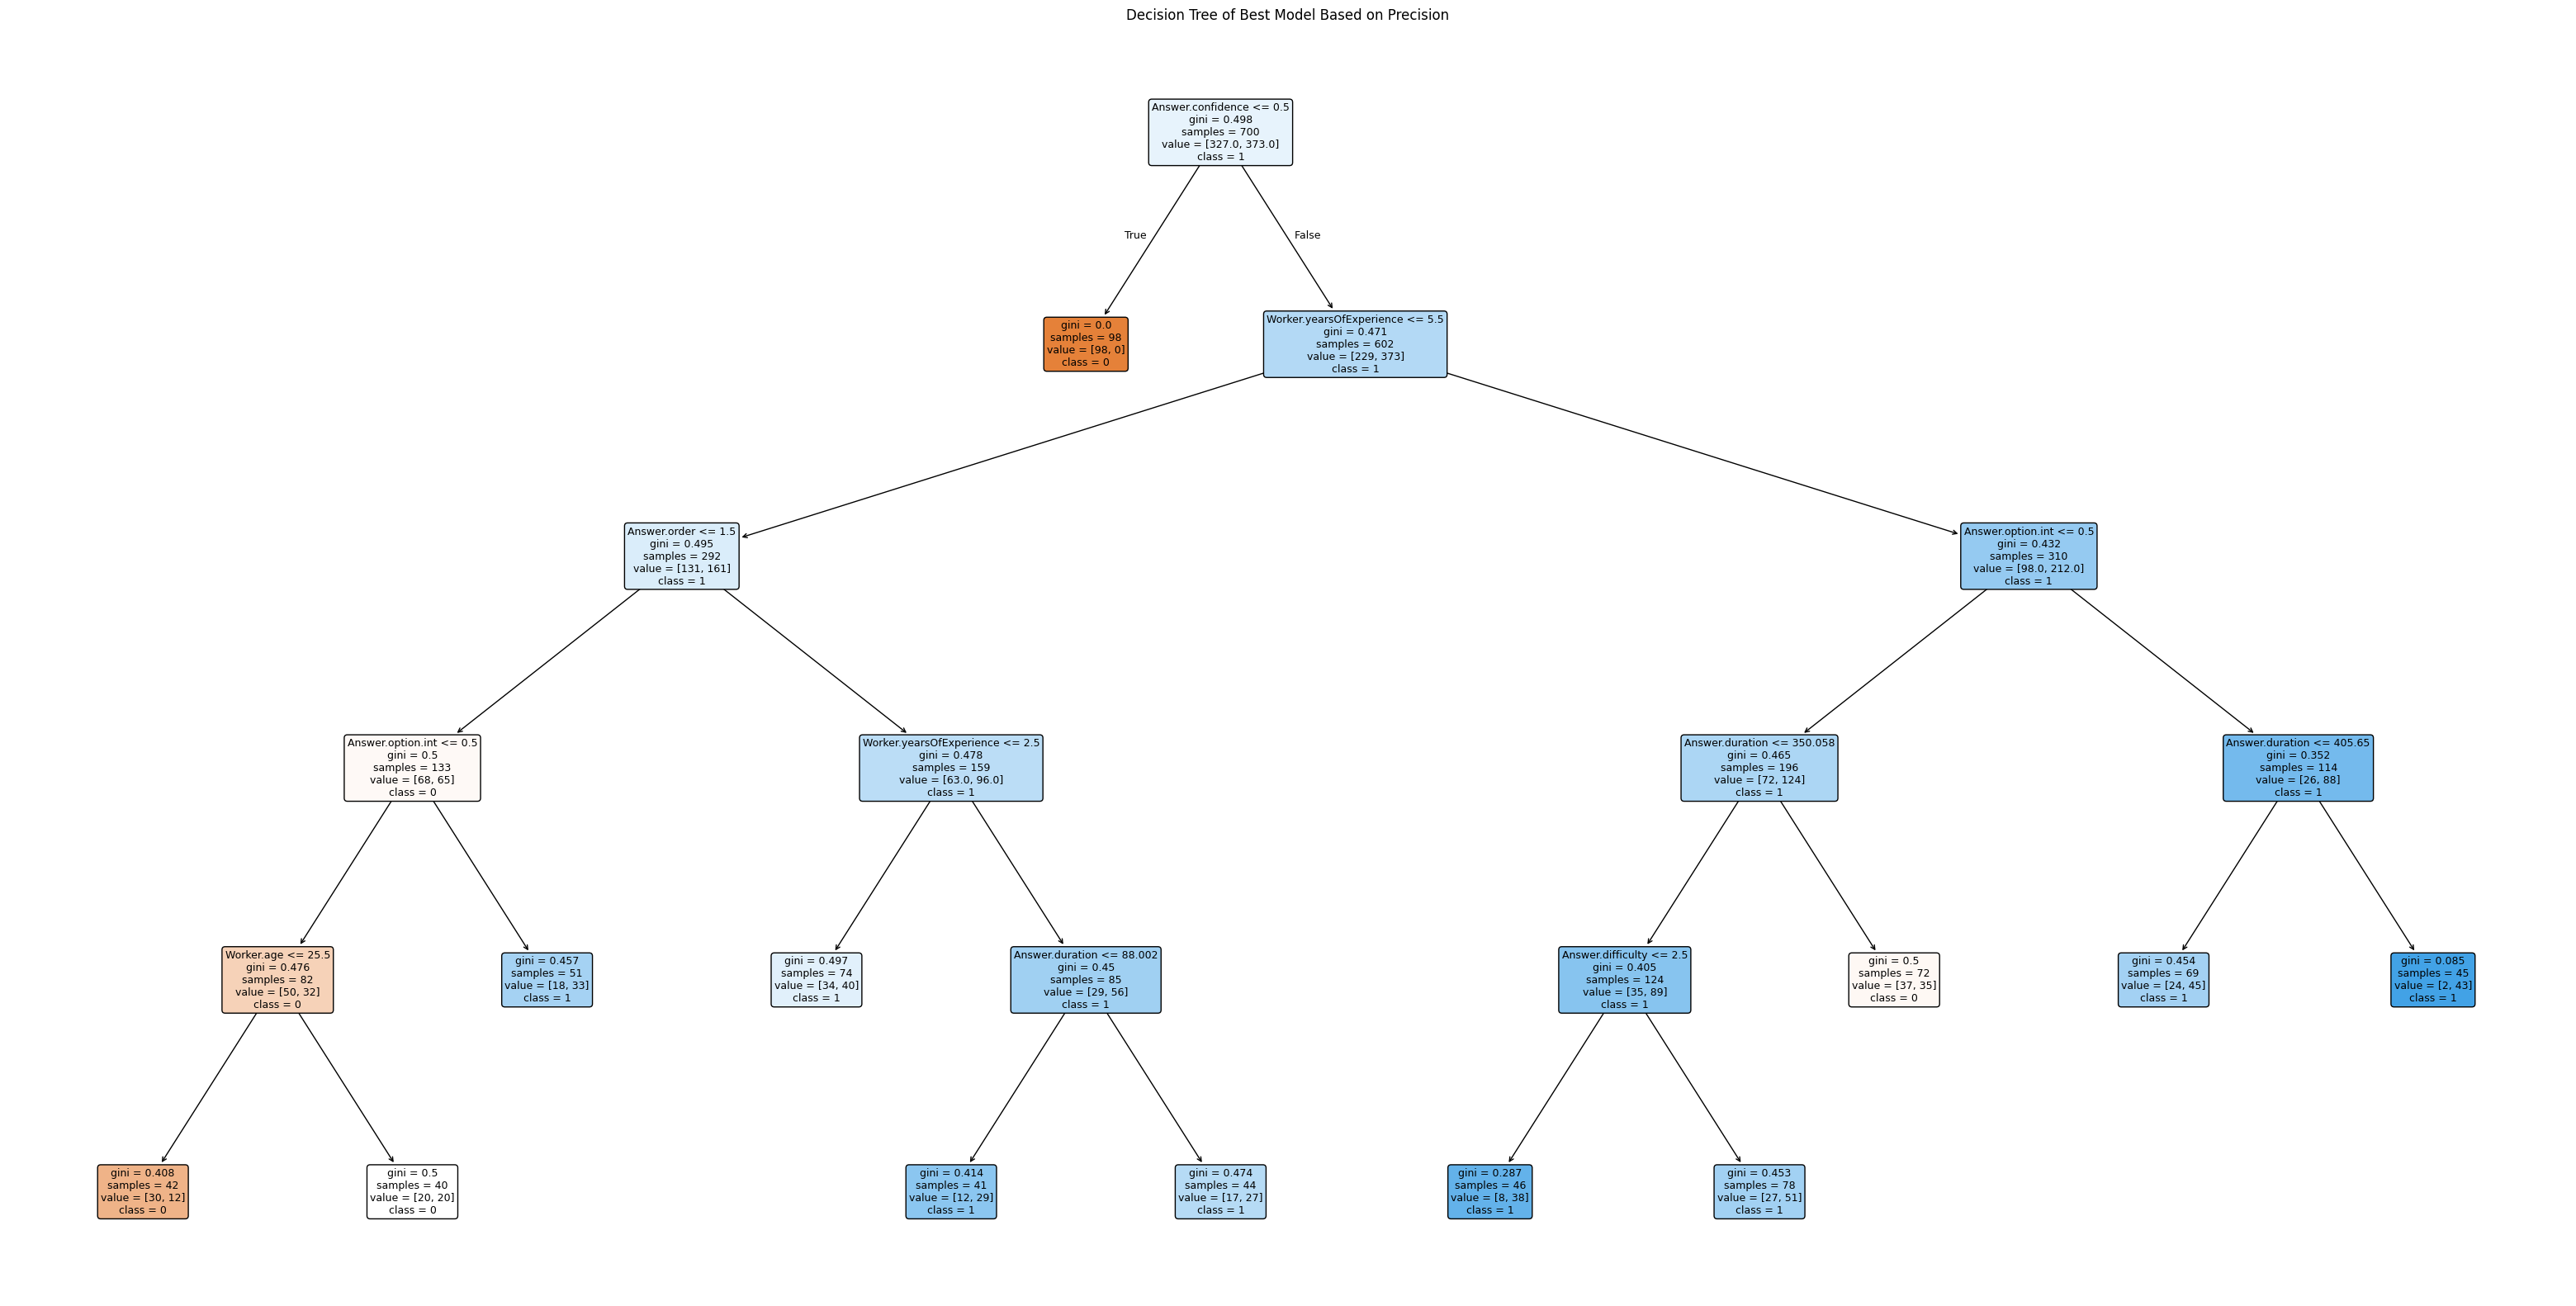

In [42]:
best_model_decision_tree_classifier = get_decision_tree_classifier(min_samples_leaf=40, max_depth=5)[4]

plt.figure(figsize=(40, 20))
plot_tree(best_model_decision_tree_classifier, filled=True, feature_names=input_cols, class_names=np.unique(y).astype(str), rounded=True, fontsize=9)
plt.title("Decision Tree of Best Model Based on Precision")
plt.show()

The precision and recall already look pretty good. Something which we noted in the first run is the fact that classes are almost entirely split with the first node in the tree. This is due to a class imbalance. We almost have double as much values where `GroundTruth` is `1`. For this reason we balanced the initial dataset. This way we are not relying on the distribution of the initial dataset. We then trained the model, which can be seen above.

To interpret this tree, we looked at the nodes most close to the root node. With this we can identify the most relevant input columns. In this case it is the users confidence and years of experience.

We are also concerned about how easily we can incorporate user demographics into our model. This raises ethical issues, as it could lead to unintended biases or discrimination.

In [10]:
df_train.groupby('GroundTruth').size()

GroundTruth
0    439
1    420
dtype: int64

## Second Tree: Gradient Boosting Classifier

No significant change in precision from average 0.63 to 0.64.

No significant change in recall from average 0.77 to 0.74.

Mean Precision train: 0.8270604276895323
Mean Recall train: 0.9483404468679061
Precision for each fold: [0.63157895 0.725      0.69026549 0.59302326 0.59302326 0.58181818]
Mean Precision: 0.635784854590029
Recall for each fold: [0.71641791 0.76821192 0.74285714 0.73913043 0.73913043 0.74418605]
Mean Recall: 0.7416556483185918


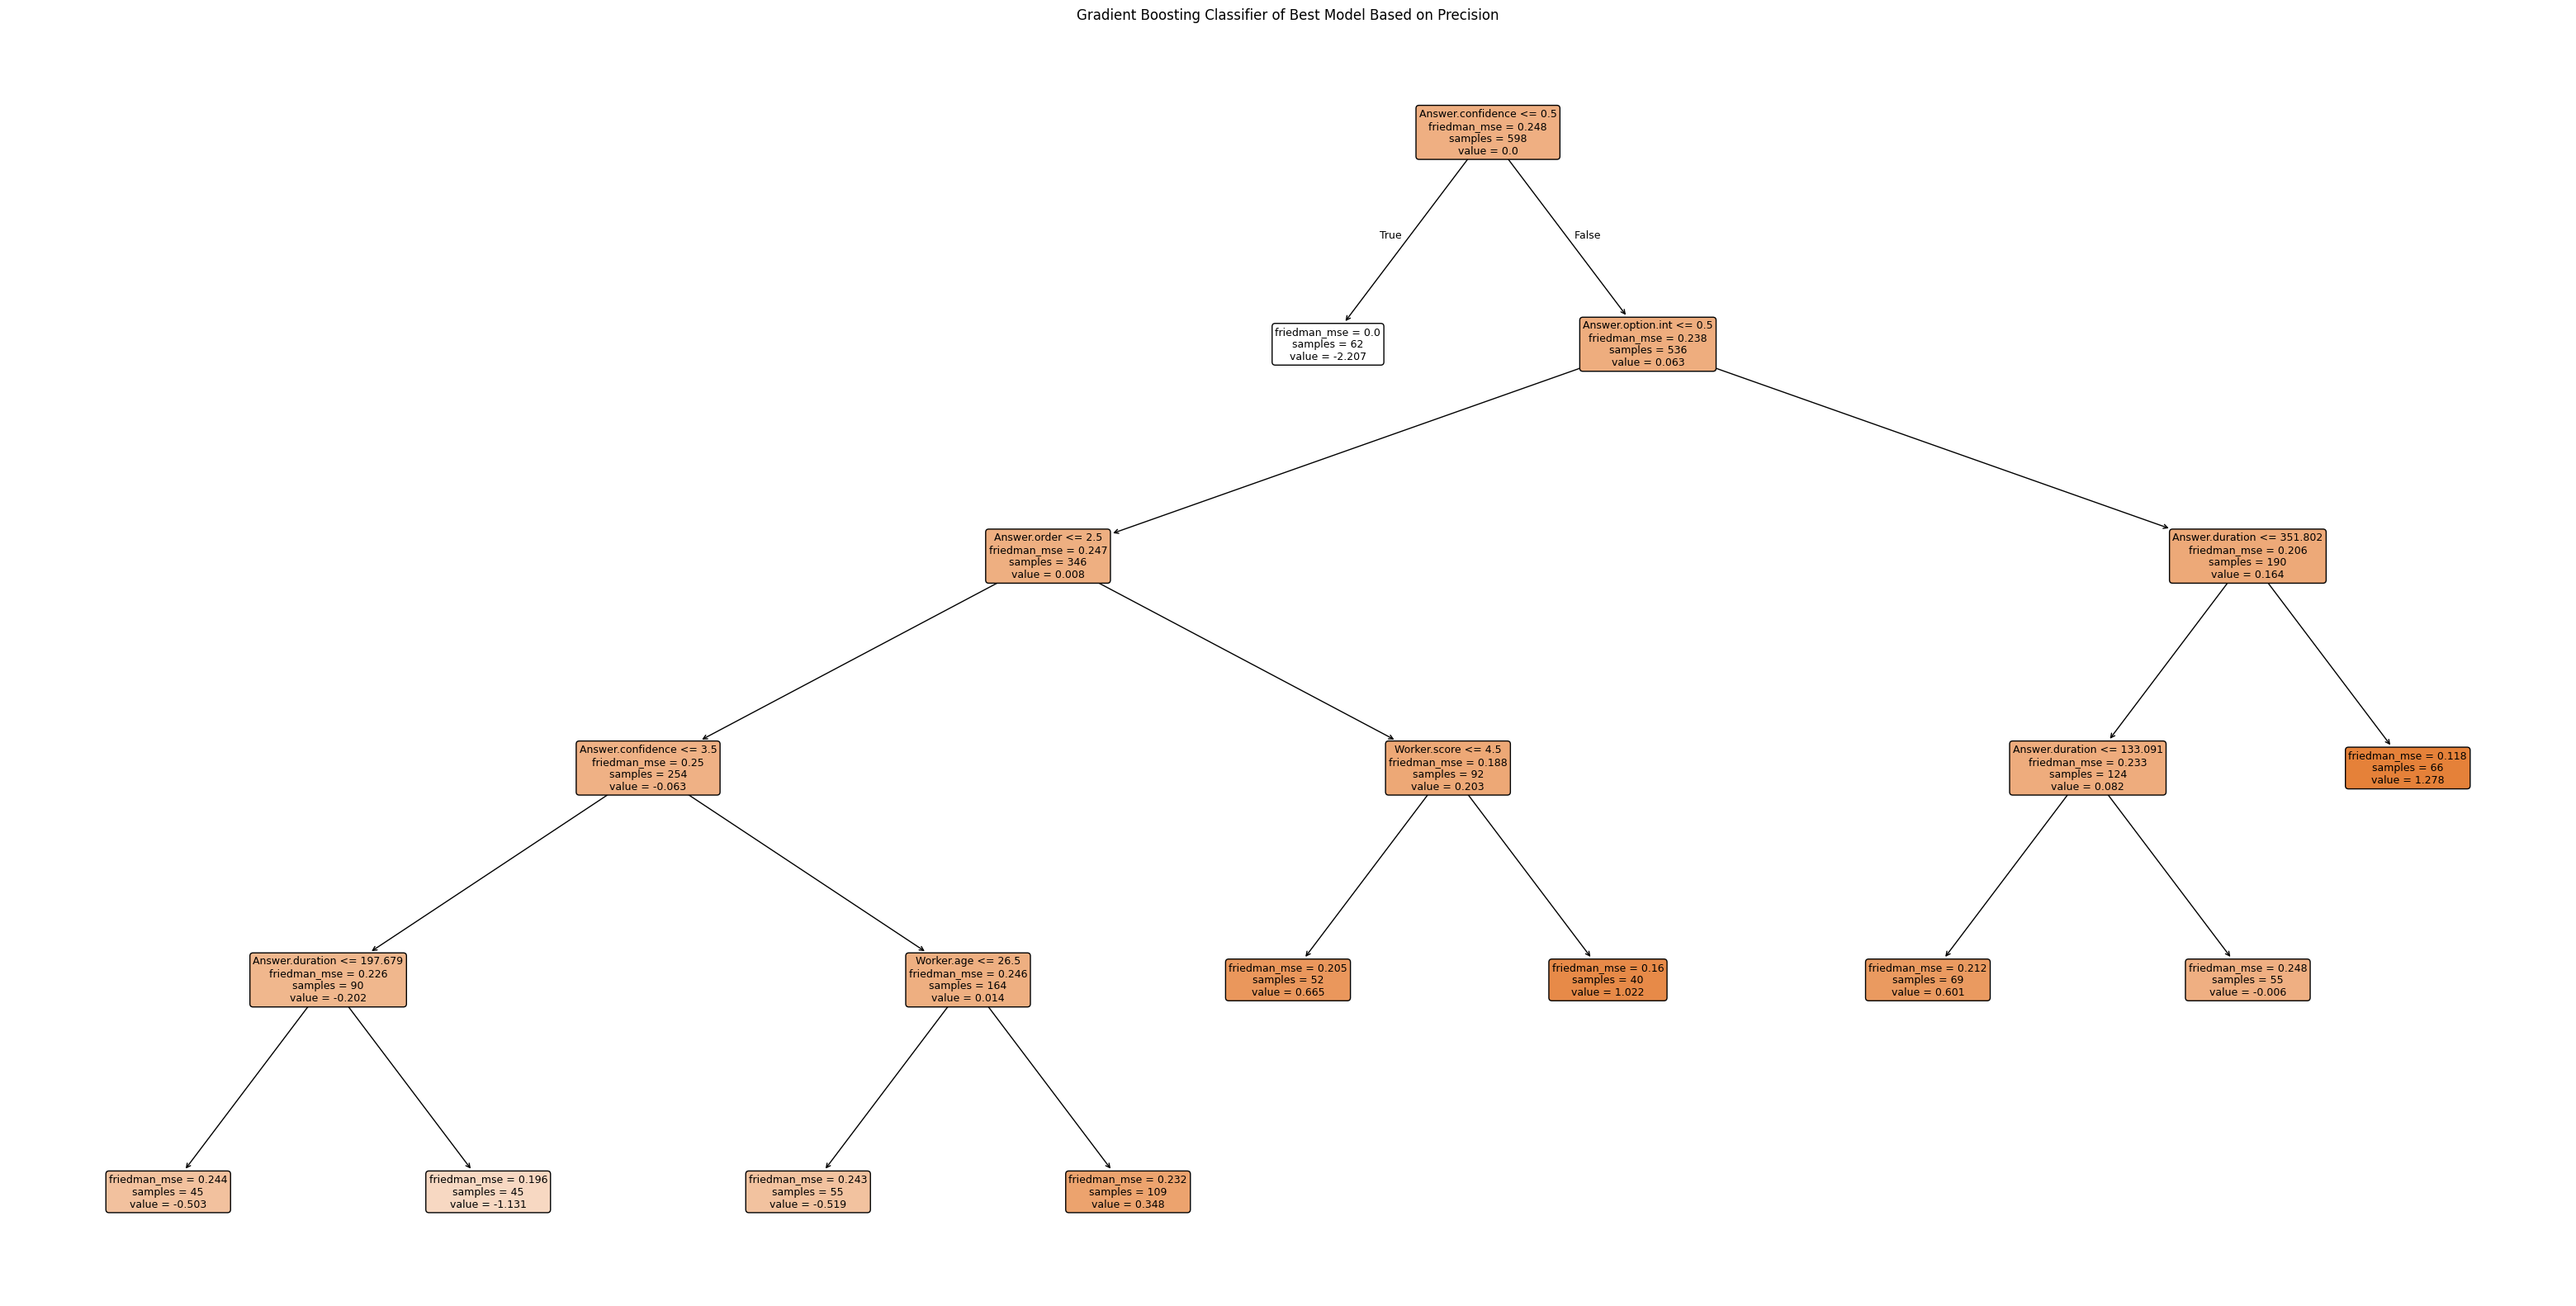

In [43]:
from sklearn.ensemble import GradientBoostingClassifier


input_cols_full = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.profession', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
input_cols = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
output_col = 'correctness'

X_gb = df_train[input_cols]
y_gb = df_train[output_col]

groups = df_train['FailingMethod'].values
gss = GroupShuffleSplit(n_splits=len(pd.unique(groups)), test_size=1/len(pd.unique(groups)))

clf = GradientBoostingClassifier(min_samples_leaf=40, max_depth=5)


cv_results = cross_validate(
        clf, X_gb, y_gb, cv=gss, groups=groups,
        scoring=['precision', 'recall'],
        return_estimator=True,
        return_train_score=True
    )

print("Mean Precision train:", np.mean(cv_results['train_precision']))
print("Mean Recall train:", np.mean(cv_results['train_recall']))

print("Precision for each fold:", cv_results['test_precision'])
print("Mean Precision:", np.mean(cv_results['test_precision']))

print("Recall for each fold:", cv_results['test_recall'])
print("Mean Recall:", np.mean(cv_results['test_recall']))

best_model_gb_idx = np.argmax(cv_results['test_precision'])
best_model_gb = cv_results['estimator'][best_model_gb_idx]

# print tree
plt.figure(figsize=(40, 20))
plot_tree(best_model_gb.estimators_[0][0], filled=True, feature_names=input_cols, class_names=np.unique(y).astype(str), rounded=True, fontsize=9)
plt.title("Gradient Boosting Classifier of Best Model Based on Precision")
plt.show()


## Third Tree: Minimal number of input columns for decision tree

By reducing number of inputs change in precision from 0.63 to 0.65.

By reducing number of inputs change in recall from 0.77 to 0.88.

Mean Precision train: 0.6507831219516133
Mean Recall train: 0.927357086103617
Precision for each fold: [0.71186441 0.59047619 0.59047619 0.71186441 0.68055556 0.59047619]
Mean Precision: 0.6459521567572415
Recall for each fold: [0.83443709 0.89855072 0.89855072 0.83443709 0.93333333 0.89855072]
Mean Recall: 0.8829766132386346


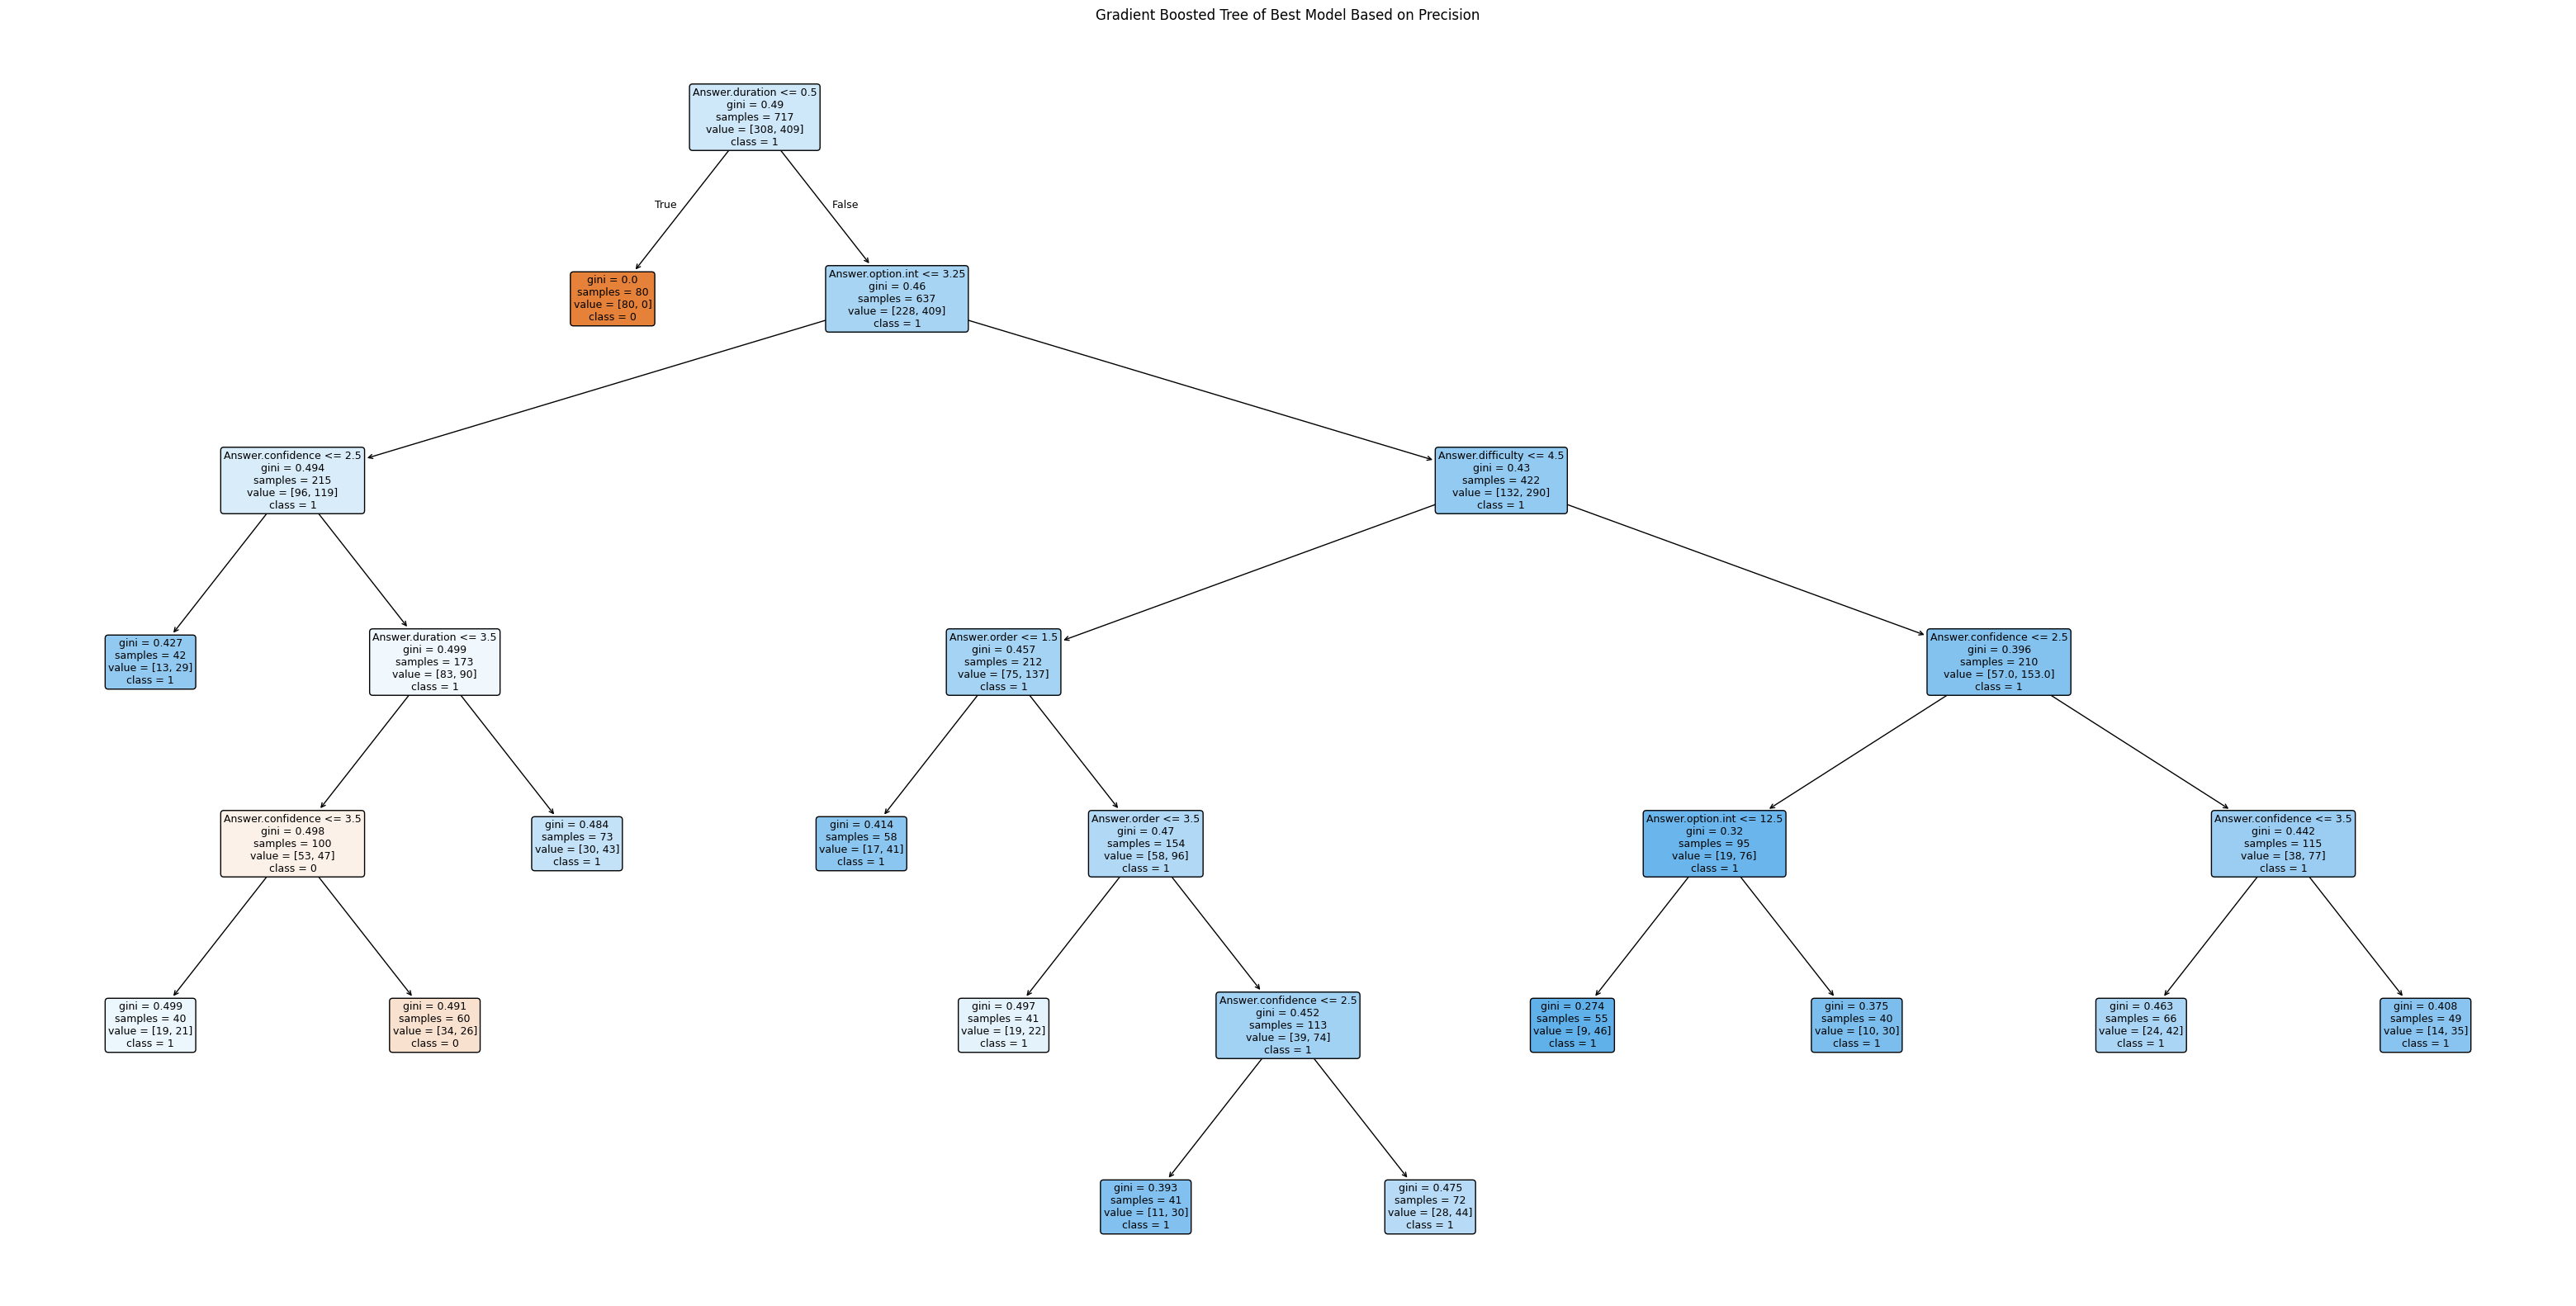

In [48]:
input_cols_full = ['Answer.duration', 'Answer.confidence', 'Answer.difficulty', 'Answer.option.int', 'Answer.order', 'Worker.score', 'Worker.profession.int', 'Worker.yearsOfExperience', 'Worker.age', 'Worker.gender.int', 'TTR']
input_cols_minimal = ['Answer.confidence', 'Answer.difficulty', 'Worker.score', 'Worker.yearsOfExperience', 'Worker.profession.int']
output_col = 'correctness'

X_gb = df_train[input_cols_minimal]
y_gb = df_train[output_col]

groups = df_train['FailingMethod'].values
gss = GroupShuffleSplit(n_splits=len(pd.unique(groups)), test_size=1/len(pd.unique(groups)))

clf = DecisionTreeClassifier(min_samples_leaf=40, max_depth=10)

cv_results = cross_validate(
        clf, X_gb, y_gb, cv=gss, groups=groups,
        scoring=['precision', 'recall'],
        return_estimator=True,
        return_train_score=True
    )

print("Mean Precision train:", np.mean(cv_results['train_precision']))
print("Mean Recall train:", np.mean(cv_results['train_recall']))

print("Precision for each fold:", cv_results['test_precision'])
print("Mean Precision:", np.mean(cv_results['test_precision']))

print("Recall for each fold:", cv_results['test_recall'])
print("Mean Recall:", np.mean(cv_results['test_recall']))

best_model_gb_min_idx = np.argmax(cv_results['test_precision'])
best_model_gb_min = cv_results['estimator'][best_model_gb_idx]

plt.figure(figsize=(40, 20))
plot_tree(best_model_gb_min, filled=True, feature_names=input_cols, class_names=np.unique(y).astype(str), rounded=True, fontsize=9)
plt.title("Gradient Boosted Tree of Best Model Based on Precision")
plt.show()


In [13]:
df_train

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR,Answer.option.int,Worker.gender.int,Worker.profession.int
0,2351,HIT06_51,92,376.040,2,5,1,1,0,0,...,24,Female,Web,india,python,1,0.882353,1.0,1,1
1,342,HIT03_6,19,172.453,4,2,0,0,1,0,...,19,Male,High School;University;Web,United States,C++; Java,1,0.775510,0.0,-1,2
2,751,HIT04_7,33,27.374,4,4,0,0,1,0,...,26,Female,High School;University;Web,USA,java,1,1.000000,0.0,1,4
3,1439,HIT07_33,104,53.939,5,2,1,1,0,0,...,32,Male,University;Web,USA,php,1,0.923077,1.0,-1,4
5,567,HIT03_6,25,91.074,5,1,0,0,0,0,...,35,Male,Web,USA,JAVA; C,0,0.941176,1.0,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1905,HIT06_51,84,253.628,0,2,1,0,0,1,...,36,Male,Web,united states,C++,0,0.920000,0.5,-1,1
996,1241,HIT04_7,65,177.237,3,3,0,0,1,0,...,29,Male,Web,united States,Java,1,1.000000,0.0,-1,4
997,1342,HIT04_7,60,599.167,2,4,0,0,1,0,...,50,Male,University;Web,USA,C++,1,0.888889,0.0,-1,0
998,1429,HIT07_33,104,507.941,5,1,1,1,0,0,...,29,Female,University;Web,USA,JAVA,1,0.928571,1.0,1,4


## Holdout set predicition

Here we use the last model to label each row from the holdout set.

In [49]:
groups = df_holdout.groupby('FailingMethod')

precision_per_group = {}
recall_per_group = {}

for method, group in groups:
    X_group = group[input_cols_minimal]
    y_group = group[output_col]

    y_pred = best_model_gb_min.predict(X_group)

    precision = precision_score(y_group, y_pred)
    recall = recall_score(y_group, y_pred)

    precision_per_group[method] = precision
    recall_per_group[method] = recall

for method in precision_per_group:
    print(f"FailingMethod: {method}")
    print(f"Precision: {precision_per_group[method]}")
    print(f"Recall: {recall_per_group[method]}")
    print("-" * 30)


FailingMethod: HIT01_8
Precision: 0.7692307692307693
Recall: 0.9836065573770492
------------------------------
FailingMethod: HIT02_24
Precision: 0.5660377358490566
Recall: 1.0
------------------------------


/var/folders/f7/k6ksdyss1rdd4kq9f0lc_kl00000gn/T/ipykernel_34613/1012204187.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bug_rows['Explanation_Size'] = bug_rows['Answer.explanation'].apply(len)


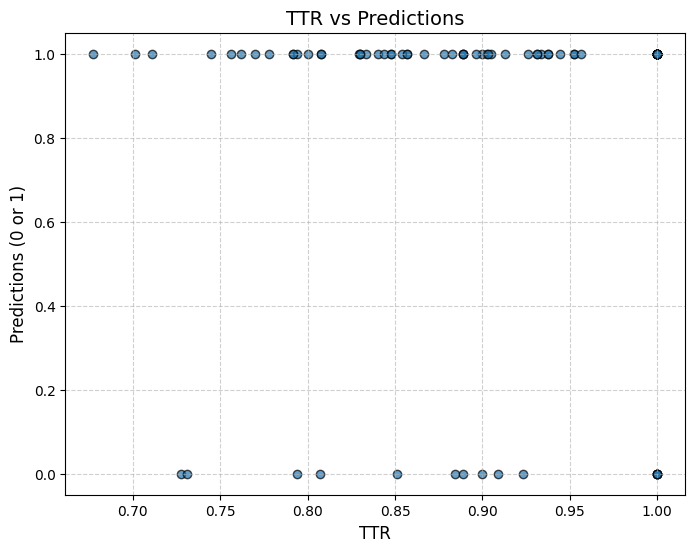

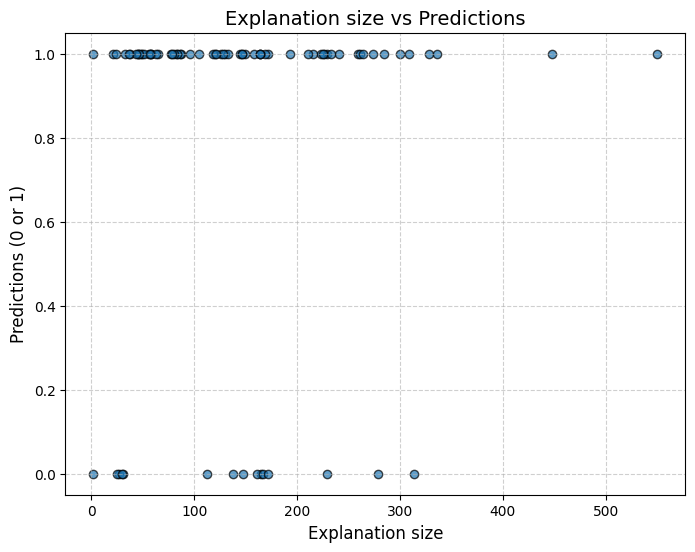

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

bug_rows = df_holdout[df_holdout['GroundTruth'] == 1]

bug_rows['Explanation_Size'] = bug_rows['Answer.explanation'].apply(len)

y_pred = best_model_decision_tree_classifier.predict(bug_rows[input_cols])


plt.figure(figsize=(8, 6))
plt.scatter(bug_rows['TTR'], y_pred, alpha=0.7, edgecolor='k')
plt.title('TTR vs Predictions', fontsize=14)
plt.xlabel('TTR', fontsize=12)
plt.ylabel('Predictions (0 or 1)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(bug_rows['Explanation_Size'], y_pred, alpha=0.7, edgecolor='k')
plt.title('Explanation size vs Predictions', fontsize=14)
plt.xlabel('Explanation size', fontsize=12)
plt.ylabel('Predictions (0 or 1)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In the diagrams above we look at rows that host a bug. We then display the distribution of our predicted values by explanation complexity (TTR) and explanation size.

In [16]:
df_holdout[df_holdout['TP'] == 1 ]


,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage,correctness,TTR,Answer.option.int,Worker.gender.int,Worker.profession.int
28,448,HIT01_8,1,259.790,3,3,1,1,0,0,...,30,Female,University,united states,none,1,0.902439,1.0,1,1
37,456,HIT01_8,1,58.673,5,1,1,1,0,0,...,25,Male,High School;University;Other forever,USA,c++,1,0.878049,1.0,-1,4
86,82,HIT02_24,14,74.804,3,3,1,1,0,0,...,32,Male,University,USA,SQL,1,0.925926,1.0,-1,4
116,243,HIT01_8,4,218.695,5,4,1,1,0,0,...,24,Male,High School;University;Web,United States,C++;Java;PHP,1,0.847826,1.0,-1,4
138,73,HIT02_24,10,105.015,5,3,1,1,0,0,...,33,Male,High School;University,USA,C#,1,0.952381,1.0,-1,4
151,68,HIT02_24,10,156.707,2,3,1,1,0,0,...,25,Male,University,India,JAVA,1,1.000000,1.0,-1,4
282,256,HIT01_8,4,50.738,5,1,1,1,0,0,...,33,Female,High School;University;Other work,US,Java,1,1.000000,1.0,1,3
289,449,HIT01_8,1,230.142,4,3,1,1,0,0,...,35,Male,High School,USA,php and C++,1,0.830189,1.0,-1,2
297,445,HIT01_8,1,261.928,5,2,1,1,0,0,...,25,Female,University,USA,java,1,0.770000,1.0,1,3
305,78,HIT02_24,10,88.588,4,5,1,1,0,0,...,26,Male,University,india,java,1,0.904762,1.0,-1,4


## Specification II

In [17]:
question_groups = df_holdout[df_holdout['TP'] == 1 ].groupby(['FailingMethod', 'Question.ID'])

explanations_list = []

for m, group in question_groups:
    explanations = group['Answer.explanation'].to_list()
    explanations_list.append(explanations)
    print('Number of explanations', len(group['Answer.explanation']))


print('Number of groups', len(question_groups))


Number of explanations 12
Number of explanations 15
Number of explanations 2
Number of explanations 9
Number of explanations 9
Number of groups 5


We created two prompts to compare the results of the different consolidations. The first prompt contains an introduction and then the specification as given on the slides. The second bug is a rewrite of the task while specifying that the result should be as short as possible.

In [18]:
def get_prompt_1(explanations):
        return f"""
I give you the following task, afterwards the relevant data. You have to solve the task with the data (filtered explanations) I give you. 
Each separate explanation is separated by a newline character

for the correct answers to the inspection tasks hosting the bug, prompt the LLM
to generate a single explanation by merging the participants’ explanations in a way that minimizes
redundant information, while keeping the information that would be necessary for someone else to fix the
bug.
• Types of information that, if present in the explanation, should be preserved - how the program works,
how the failure is happening, what is problem in the code, etc.

{explanations}

"""

def get_prompt_2(explanations):
        return f"""
Please summarize these reports of the same bug. 
Remove redundant information, but make sure that every information given in the explanations is retained that would be needed to fix the bug. 
Summarize the report of the bug concisely. Keep the summary as short as possible.

These are the reports:

{explanations}

"""

In [19]:
for explanations in explanations_list:
    print(get_prompt_2(str(explanations)))


Please summarize these reports of the same bug. 
Remove redundant information, but make sure that every information given in the explanations is retained that would be needed to fix the bug. 
Summarize the report of the bug concisely. Keep the summary as short as possible.

These are the reports:

['This variable contains a value of -15 as set by DateTimeZone.forOffsetHoursMinutes(-2; -15). Line 279 checks to see if is a valid value; meaning that is between 0 and 59. Since it is not; an exception error is thrown in line 280.', "yep; they are checking if minutesOffset < 0 to throw an exception; and as -15 <0; it gets thrown. looks like they updated the comments but not the code. and this is why comments are evil liars that can't be trusted!", 'Yes; the variable gets set to -15 through the arguments above. The code specifically encounters the error on line 279 when it tests if minutesOffset < 0; (-15) which is the case; so it throws the error on line 280 : Minutes out of range: with the

In [53]:
from openai import OpenAI
client = OpenAI(
    api_key=""
)

def get_results(get_prompt_function):

    results = []

    for explanations in tqdm(explanations_list):

        chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": get_prompt_function(str(explanations)),
            }
        ],
        model="gpt-4o-mini",
    )

        results.append(chat_completion.choices[0].message.content)

    results_df = pd.DataFrame(results, columns=['text']).reset_index()

    results_df['complexity'] = results_df['text'].astype(str).apply(calculate_ttr)
    results_df['length'] = results_df['text'].astype(str).apply(len)

    return results_df

In [70]:
prompt_1_results = get_results(get_prompt_1)
prompt_1_results

  0%|          | 0/5 [00:00<?, ?it/s]

,index,text,complexity,length
0,0,The issue arises from the handling of the vari...,0.709497,1168
1,1,The code has an issue with handling negative m...,0.662069,942
2,2,The issue in the program arises from the logic...,0.787500,464
3,3,The issue in the program arises from incorrect...,0.680851,888
4,4,"The issue seems to stem from the variable ""g"",...",0.671233,920


In [71]:
prompt_2_results = get_results(get_prompt_2)
prompt_2_results

  0%|          | 0/5 [00:00<?, ?it/s]

,index,text,complexity,length
0,0,The bug arises from an incorrect check on line...,0.790123,488
1,1,The bug occurs due to the condition on line 27...,0.705263,601
2,2,"The bug is in line 279, where the variable ""mi...",0.680851,240
3,3,**Bug Summary:**\n\nThere is a bug in the colo...,0.724490,641
4,4,The bug report identifies a potential issue wi...,0.698795,519


Here we can find the generated results. As you can see the first prompt generated results with a higher length and less complexity. Alone these two metrics show what we commonly see when using LLMs, they repeat themselves.
When actually reading through the outputs you can also see that with the first prompt, we have more repetition of information then with the second one. The results of the second also feel way more concise and better to read.

In [72]:
from IPython.core.display import Markdown


for index, (text1, text2) in enumerate(zip(prompt_1_results['text'], prompt_2_results['text'])):
    display(Markdown(f'## Text {index + 1}'))
    display(Markdown(f'### Prompt 1'))
    display(Markdown(text1))
    display(Markdown(f'### Prompt 2'))
    display(Markdown(text2))

## Text 1

### Prompt 1

The issue arises from the handling of the variable "minutesOffset," which is set to -15 through the method `DateTimeZone.forOffsetHoursMinutes(-2, -15)`. On line 279, the code checks if `minutesOffset < 0` to determine whether to throw an exception. Since -15 is indeed less than 0, the program throws an exception on line 280 with the message "Minutes out of range: -15." 

The current implementation incorrectly uses this single condition to validate the range of "minutesOffset," which must actually be between -59 and +59 according to the documentation. Therefore, line 279 should be modified to check the bounds correctly as: `if (minutesOffset < -59 || minutesOffset > 59) {`. 

Additionally, there's a suggestion that the variable "minutesOffset" could be defined as "unsigned int" if a positive value is always expected. However, the intended functionality states that "minutesOffset" can indeed be negative, which must be taken into account in the range check.

Overall, the primary problem is that the existing logic does not accommodate for valid negative values, leading to the unnecessary exception being thrown in scenarios where negative input is valid.

### Prompt 2

The bug arises from an incorrect check on line 279 of the code, where the variable "minutesOffset" is validated. Currently, it throws an exception for any value < 0, which includes -15, leading to an "illegal argument" error. The check should be adjusted to allow negative values within the valid range of -59 to +59. The correct condition should be: `if (minutesOffset < -59 || minutesOffset > 59) {`. This ensures that valid negative offsets are accepted according to the documentation.

## Text 2

### Prompt 1

The code has an issue with handling negative minute offsets when the hour input is also negative. Specifically, the method checks if the `minutesOffset` is less than 0 or greater than 59, which results in an `IllegalArgumentException` when a negative value like -15 is passed, as is evident in the call to `DateTimeZone.forOffsetHoursMinutes(-2, -15)`. The conditional on line 279 is responsible for this exception, as it rejects any negative minute input outright, without considering whether the hour input is negative, which may be a valid scenario according to the comments. The comments indicate that negative minutes are acceptable when the hour is also negative, but the existing condition doesn't accommodate this logic, thus leading to incorrect error handling. To fix this, the code should also check if the hour is negative before rejecting negative minute values or appropriately evaluate minutes against their valid range limits.

### Prompt 2

The bug occurs due to the condition on line 279, which checks if `minutesOffset` is less than 0, leading to an exception on line 280 when negative minute values (e.g., -15) are passed. The method's comment specifies that `minutesOffset` should be between -59 and +59, but the conditional only allows positive minute values. This logic does not account for negative hours, which should permit negative minutes. To fix the bug, the conditional should be adjusted to reject negative minutes only when hours are positive, ensuring that both negative and positive minute values are validated appropriately.

## Text 3

### Prompt 1

The issue in the program arises from the logic on line 279, where the variable "minutesOffSet" is incorrectly set to throw an exception if it is less than 0. To resolve this, the condition should be altered to check for values less than -59 instead. Additionally, the "offset" variable remains at zero, which contributes to it being out of the acceptable range. This indicates that there are problems with how the offset values are defined and handled in the code.

### Prompt 2

The bug is in line 279, where the variable "minutesOffSet" is incorrectly set to throw an exception if it is < 0. It should be modified to throw an exception if it is < -59. The "offset" variable remains zero, causing it to be out of range.

## Text 4

### Prompt 1

The issue in the program arises from incorrect handling of color values, specifically in relation to the parameters used for a Color object. The method does not ensure that the lower range of values is positive, which may lead to the acceptance of negative numbers, as seen with the value -0.5. The code checks the argument against lowerBound and upperBound variables, but the resultant variable 'v' is never utilized, allowing 'value' to exceed the valid range. This results in 'g' potentially producing a negative value or exceeding 255, both of which are invalid for Color objects. Moreover, there is a mistake where 'value' is used instead of 'v' on line 117, further complicating the validation process. Without proper validation and the use of the correct variables, illegal arguments such as negative color values could lead to runtime exceptions, such as IllegalArgumentException.

### Prompt 2

**Bug Summary:**

There is a bug in the color processing method where the lower range of value is not checked for positivity, allowing negative inputs (e.g., -0.5), leading to illegal color values. The constructor requires values between 0.0 and 1.0; however, the argument is not being sanitized, which allows values to exceed the valid range (0 to 255) for the Color object. The variable "value" is incorrectly used instead of "v" (calculated from lowerBound and upperBound), causing the method to encounter out-of-bounds issues. An `IllegalArgumentException` is thrown for illegal inputs due to these checks not being implemented properly.

## Text 5

### Prompt 1

The issue seems to stem from the variable "g", which is defined as an integer but is expected to fall within certain acceptable range values of the Color class. It appears that the calculation of "g" could result in a negative integer, especially if the initial parameter value provided is negative. This would lead to the Color constructor throwing an IllegalArgumentException due to the color parameter being outside the expected range.

There is also a suggestion that "g" should be a float number instead of an integer, and it should be computed using the variable "v" rather than "value". Without knowing the specifics of the methods defining the expected boundaries (this.lowerBound and this.upperBound), it's unclear how these limits influence the validity of "g". Overall, the crux of the problem lies in how "g" is calculated and its resultant value being inappropriate for the Color constructor's requirements.

### Prompt 2

The bug report identifies a potential issue with the variable "g," which is likely being defined as an integer rather than a float and may fall outside the acceptable range of the Color class. The value of "g" can result in a negative integer when derived from a negative input parameter, leading to an IllegalArgumentException due to the Color constructor. Further examination of the definitions for this.lowerBound and this.upperBound is required to confirm the acceptable range and understand the cause of the error.

In [73]:
import nltk
from rouge import Rouge

def calculate_bleu(hyp, ref):
    hypothesis = hyp.split()
    reference = ref.split()
    return nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)

rouge = Rouge()
def calculate_rouge(hyp, ref):
    scores = rouge.get_scores(hyp, ref)
    return scores[0]['rouge-1']['f']

In [74]:
def display_bleu_rouge(prompt_results):
    explanation_indices = []
    hyp_texts = []
    ref_texts = []
    bleu_vals = []
    rouge_vals = []

    for index, explanations in enumerate(explanations_list):
        hyp = prompt_results.iloc[index]['text']

        for ref in explanations:
            if len(ref.split(' ')) < 5:
                continue
            explanation_indices.append(index)
            hyp_texts.append(hyp)
            ref_texts.append(ref)
            bleu_vals.append(calculate_bleu(hyp, ref))
            rouge_vals.append(calculate_rouge(hyp, ref))

    data = {
        'Explanation index': explanation_indices,
        'Hyp text': hyp_texts,
        'Ref text': ref_texts,
        'bleu': bleu_vals,
        'rouge': rouge_vals,
    }


    similarity_metrics = pd.DataFrame(data)
    display(similarity_metrics)
    return similarity_metrics

sim_1 = display_bleu_rouge(prompt_1_results)
sim_2 = display_bleu_rouge(prompt_2_results)

/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o

,Explanation index,Hyp text,Ref text,bleu,rouge
0,0,The issue arises from the handling of the vari...,This variable contains a value of -15 as set b...,2.998160e-155,0.282209
1,0,The issue arises from the handling of the vari...,yep; they are checking if minutesOffset < 0 to...,5.960903e-79,0.211180
2,0,The issue arises from the handling of the vari...,Yes; the variable gets set to -15 through the ...,4.399932e-02,0.297619
3,0,The issue arises from the handling of the vari...,YES. The issue is on line 279 (as I explained ...,6.629790e-02,0.336634
4,0,The issue arises from the handling of the vari...,"the variable should be defined as ""unsigned in...",3.238664e-02,0.171429
5,0,The issue arises from the handling of the vari...,In the code there is a check that 0 <= minutes...,2.696024e-155,0.197368
6,0,The issue arises from the handling of the vari...,The value of minutes offset does not have vali...,2.159663e-155,0.178082
7,0,The issue arises from the handling of the vari...,Minutes are set to -15; which is less then 0 a...,2.232975e-155,0.113475
8,0,The issue arises from the handling of the vari...,"The variable ""minutesOffset"" is checked incorr...",2.144693e-02,0.258065
9,0,The issue arises from the handling of the vari...,As noted in the comments; valid input for minu...,2.924451e-02,0.265896


/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lucas/PycharmProjects/ASE-GenAI/venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o

,Explanation index,Hyp text,Ref text,bleu,rouge
0,0,The bug arises from an incorrect check on line...,This variable contains a value of -15 as set b...,3.156925e-155,0.274510
1,0,The bug arises from an incorrect check on line...,yep; they are checking if minutesOffset < 0 to...,1.105949e-231,0.200000
2,0,The bug arises from an incorrect check on line...,Yes; the variable gets set to -15 through the ...,1.365551e-78,0.336449
3,0,The bug arises from an incorrect check on line...,YES. The issue is on line 279 (as I explained ...,9.240543e-02,0.340426
4,0,The bug arises from an incorrect check on line...,"the variable should be defined as ""unsigned in...",3.094381e-155,0.151899
5,0,The bug arises from an incorrect check on line...,In the code there is a check that 0 <= minutes...,1.051835e-231,0.175824
6,0,The bug arises from an incorrect check on line...,The value of minutes offset does not have vali...,9.504404e-232,0.141176
7,0,The bug arises from an incorrect check on line...,Minutes are set to -15; which is less then 0 a...,2.704288e-155,0.175000
8,0,The bug arises from an incorrect check on line...,"The variable ""minutesOffset"" is checked incorr...",1.162379e-78,0.297872
9,0,The bug arises from an incorrect check on line...,As noted in the comments; valid input for minu...,7.013263e-02,0.321429


Here we computed the BLEU and ROUGE scores for each pairing of LLM generated explanation and original explanation. We directly notice that the BLEU score always is way smaller than the ROUGE score. Since we have a text summarization task here and BLEU is designed to be used for scoring machine translations and ROUGE for scoring text summarization, this makes perfect sense.

To better compare these values, we calculate the mean and median for each generated explanation for the results of prompt 1 and 2.

In [75]:
def group_similarities_mean(similarity_metrics):
    display(similarity_metrics[['Explanation index', 'Hyp text', 'bleu', 'rouge']].groupby('Hyp text').mean())

def group_similarities_median(similarity_metrics):
    display(similarity_metrics[['Explanation index', 'Hyp text', 'bleu', 'rouge']].groupby('Hyp text').mean())

display(Markdown('## Mean'))
group_similarities_mean(sim_1)
group_similarities_mean(sim_2)

display(Markdown('## Median'))
group_similarities_median(sim_1)
group_similarities_median(sim_2)

## Mean

,Explanation index,bleu,rouge
Hyp text,,,
"The code has an issue with handling negative minute offsets when the hour input is also negative. Specifically, the method checks if the `minutesOffset` is less than 0 or greater than 59, which results in an `IllegalArgumentException` when a negative value like -15 is passed, as is evident in the call to `DateTimeZone.forOffsetHoursMinutes(-2, -15)`. The conditional on line 279 is responsible for this exception, as it rejects any negative minute input outright, without considering whether the hour input is negative, which may be a valid scenario according to the comments. The comments indicate that negative minutes are acceptable when the hour is also negative, but the existing condition doesn't accommodate this logic, thus leading to incorrect error handling. To fix this, the code should also check if the hour is negative before rejecting negative minute values or appropriately evaluate minutes against their valid range limits.",1.0,0.009993,0.167350
"The issue arises from the handling of the variable ""minutesOffset,"" which is set to -15 through the method `DateTimeZone.forOffsetHoursMinutes(-2, -15)`. On line 279, the code checks if `minutesOffset < 0` to determine whether to throw an exception. Since -15 is indeed less than 0, the program throws an exception on line 280 with the message ""Minutes out of range: -15."" \n\nThe current implementation incorrectly uses this single condition to validate the range of ""minutesOffset,"" which must actually be between -59 and +59 according to the documentation. Therefore, line 279 should be modified to check the bounds correctly as: `if (minutesOffset < -59 || minutesOffset > 59) {`. \n\nAdditionally, there's a suggestion that the variable ""minutesOffset"" could be defined as ""unsigned int"" if a positive value is always expected. However, the intended functionality states that ""minutesOffset"" can indeed be negative, which must be taken into account in the range check.\n\nOverall, the primary problem is that the existing logic does not accommodate for valid negative values, leading to the unnecessary exception being thrown in scenarios where negative input is valid.",0.0,0.019810,0.232314
"The issue in the program arises from incorrect handling of color values, specifically in relation to the parameters used for a Color object. The method does not ensure that the lower range of values is positive, which may lead to the acceptance of negative numbers, as seen with the value -0.5. The code checks the argument against lowerBound and upperBound variables, but the resultant variable 'v' is never utilized, allowing 'value' to exceed the valid range. This results in 'g' potentially producing a negative value or exceeding 255, both of which are invalid for Color objects. Moreover, there is a mistake where 'value' is used instead of 'v' on line 117, further complicating the validation process. Without proper validation and the use of the correct variables, illegal arguments such as negative color values could lead to runtime exceptions, such as IllegalArgumentException.",3.0,0.003606,0.198198
"The issue in the program arises from the logic on line 279, where the variable ""minutesOffSet"" is incorrectly set to throw an exception if it is less than 0. To resolve this, the condition should be altered to check for values less than -59 instead. Additionally, the ""offset"" variable remains at zero, which contributes to it being out of the acceptable range. This indicates that there are problems with how the offset values are defined and handled in the code.",2.0,0.063380,0.297297
"The issue seems to stem from the variable ""g"", which is defined as an integer but is expected to fall within certain acceptable range values of the Color class. It appears that the calculation of ""g"" could result in a negative integer, especially if the initial parameter value provided is negative. This would lead to the Color constructor throwing an IllegalArgumentE

,Explanation index,bleu,rouge
Hyp text,,,
"**Bug Summary:**\n\nThere is a bug in the color processing method where the lower range of value is not checked for positivity, allowing negative inputs (e.g., -0.5), leading to illegal color values. The constructor requires values between 0.0 and 1.0; however, the argument is not being sanitized, which allows values to exceed the valid range (0 to 255) for the Color object. The variable ""value"" is incorrectly used instead of ""v"" (calculated from lowerBound and upperBound), causing the method to encounter out-of-bounds issues. An `IllegalArgumentException` is thrown for illegal inputs due to these checks not being implemented properly.",3.0,0.017295,0.218391
"The bug arises from an incorrect check on line 279 of the code, where the variable ""minutesOffset"" is validated. Currently, it throws an exception for any value < 0, which includes -15, leading to an ""illegal argument"" error. The check should be adjusted to allow negative values within the valid range of -59 to +59. The correct condition should be: `if (minutesOffset < -59 || minutesOffset > 59) {`. This ensures that valid negative offsets are accepted according to the documentation.",0.0,0.021429,0.254912
"The bug is in line 279, where the variable ""minutesOffSet"" is incorrectly set to throw an exception if it is < 0. It should be modified to throw an exception if it is < -59. The ""offset"" variable remains zero, causing it to be out of range.",2.0,0.081127,0.387791
"The bug occurs due to the condition on line 279, which checks if `minutesOffset` is less than 0, leading to an exception on line 280 when negative minute values (e.g., -15) are passed. The method's comment specifies that `minutesOffset` should be between -59 and +59, but the conditional only allows positive minute values. This logic does not account for negative hours, which should permit negative minutes. To fix the bug, the conditional should be adjusted to reject negative minutes only when hours are positive, ensuring that both negative and positive minute values are validated appropriately.",1.0,0.007368,0.171891
"The bug report identifies a potential issue with the variable ""g,"" which is likely being defined as an integer rather than a float and may fall outside the acceptable range of the Color class. The value of ""g"" can result in a negative integer when derived from a negative input parameter, leading to an IllegalArgumentException due to the Color constructor. Further examination of the definitions for this.lowerBound and this.upperBound is required to confirm the acceptable range and understand the cause of the error.",4.0,0.011585,0.171323


## Median

,Explanation index,bleu,rouge
Hyp text,,,
"The code has an issue with handling negative minute offsets when the hour input is also negative. Specifically, the method checks if the `minutesOffset` is less than 0 or greater than 59, which results in an `IllegalArgumentException` when a negative value like -15 is passed, as is evident in the call to `DateTimeZone.forOffsetHoursMinutes(-2, -15)`. The conditional on line 279 is responsible for this exception, as it rejects any negative minute input outright, without considering whether the hour input is negative, which may be a valid scenario according to the comments. The comments indicate that negative minutes are acceptable when the hour is also negative, but the existing condition doesn't accommodate this logic, thus leading to incorrect error handling. To fix this, the code should also check if the hour is negative before rejecting negative minute values or appropriately evaluate minutes against their valid range limits.",1.0,0.009993,0.167350
"The issue arises from the handling of the variable ""minutesOffset,"" which is set to -15 through the method `DateTimeZone.forOffsetHoursMinutes(-2, -15)`. On line 279, the code checks if `minutesOffset < 0` to determine whether to throw an exception. Since -15 is indeed less than 0, the program throws an exception on line 280 with the message ""Minutes out of range: -15."" \n\nThe current implementation incorrectly uses this single condition to validate the range of ""minutesOffset,"" which must actually be between -59 and +59 according to the documentation. Therefore, line 279 should be modified to check the bounds correctly as: `if (minutesOffset < -59 || minutesOffset > 59) {`. \n\nAdditionally, there's a suggestion that the variable ""minutesOffset"" could be defined as ""unsigned int"" if a positive value is always expected. However, the intended functionality states that ""minutesOffset"" can indeed be negative, which must be taken into account in the range check.\n\nOverall, the primary problem is that the existing logic does not accommodate for valid negative values, leading to the unnecessary exception being thrown in scenarios where negative input is valid.",0.0,0.019810,0.232314
"The issue in the program arises from incorrect handling of color values, specifically in relation to the parameters used for a Color object. The method does not ensure that the lower range of values is positive, which may lead to the acceptance of negative numbers, as seen with the value -0.5. The code checks the argument against lowerBound and upperBound variables, but the resultant variable 'v' is never utilized, allowing 'value' to exceed the valid range. This results in 'g' potentially producing a negative value or exceeding 255, both of which are invalid for Color objects. Moreover, there is a mistake where 'value' is used instead of 'v' on line 117, further complicating the validation process. Without proper validation and the use of the correct variables, illegal arguments such as negative color values could lead to runtime exceptions, such as IllegalArgumentException.",3.0,0.003606,0.198198
"The issue in the program arises from the logic on line 279, where the variable ""minutesOffSet"" is incorrectly set to throw an exception if it is less than 0. To resolve this, the condition should be altered to check for values less than -59 instead. Additionally, the ""offset"" variable remains at zero, which contributes to it being out of the acceptable range. This indicates that there are problems with how the offset values are defined and handled in the code.",2.0,0.063380,0.297297
"The issue seems to stem from the variable ""g"", which is defined as an integer but is expected to fall within certain acceptable range values of the Color class. It appears that the calculation of ""g"" could result in a negative integer, especially if the initial parameter value provided is negative. This would lead to the Color constructor throwing an IllegalArgumentE

,Explanation index,bleu,rouge
Hyp text,,,
"**Bug Summary:**\n\nThere is a bug in the color processing method where the lower range of value is not checked for positivity, allowing negative inputs (e.g., -0.5), leading to illegal color values. The constructor requires values between 0.0 and 1.0; however, the argument is not being sanitized, which allows values to exceed the valid range (0 to 255) for the Color object. The variable ""value"" is incorrectly used instead of ""v"" (calculated from lowerBound and upperBound), causing the method to encounter out-of-bounds issues. An `IllegalArgumentException` is thrown for illegal inputs due to these checks not being implemented properly.",3.0,0.017295,0.218391
"The bug arises from an incorrect check on line 279 of the code, where the variable ""minutesOffset"" is validated. Currently, it throws an exception for any value < 0, which includes -15, leading to an ""illegal argument"" error. The check should be adjusted to allow negative values within the valid range of -59 to +59. The correct condition should be: `if (minutesOffset < -59 || minutesOffset > 59) {`. This ensures that valid negative offsets are accepted according to the documentation.",0.0,0.021429,0.254912
"The bug is in line 279, where the variable ""minutesOffSet"" is incorrectly set to throw an exception if it is < 0. It should be modified to throw an exception if it is < -59. The ""offset"" variable remains zero, causing it to be out of range.",2.0,0.081127,0.387791
"The bug occurs due to the condition on line 279, which checks if `minutesOffset` is less than 0, leading to an exception on line 280 when negative minute values (e.g., -15) are passed. The method's comment specifies that `minutesOffset` should be between -59 and +59, but the conditional only allows positive minute values. This logic does not account for negative hours, which should permit negative minutes. To fix the bug, the conditional should be adjusted to reject negative minutes only when hours are positive, ensuring that both negative and positive minute values are validated appropriately.",1.0,0.007368,0.171891
"The bug report identifies a potential issue with the variable ""g,"" which is likely being defined as an integer rather than a float and may fall outside the acceptable range of the Color class. The value of ""g"" can result in a negative integer when derived from a negative input parameter, leading to an IllegalArgumentException due to the Color constructor. Further examination of the definitions for this.lowerBound and this.upperBound is required to confirm the acceptable range and understand the cause of the error.",4.0,0.011585,0.171323


Here we can clearly see that the average and median BLEU and ROUGE values in 3/4 cases are larger for the explanations of prompt 2. This means that the results of the second prompt have a higher similarity with the human generated explanations than the first prompt. This observation further demonstrates that the second prompt performs better than the first one.


# Reflection

### Concerns About Guaranteeing the Quality of the Data:
- Data quality depends on participants' skills and effort.
- Explanations vary in detail and correctness, complicating classifier integration but aiding answer evaluation.
- Aggregating multiple answers (e.g., voting) reduces reliance on individual responses.
- Participants' honesty in answering the questionnaire cannot be guaranteed.

---

### Concerns About Keeping the Classifier Up-to-Date:
- Classifier insights may not generalize to different contexts (e.g., project size or domain-specific requirements).
- Demographic variations among programmers may impact classifier accuracy.
- For new domains or programmers, retraining on fresh data is essential before making predictions.

---

### Concerns About Testing the Output of the Classifier and LLM:
- Classifier output correctness can be tested effectively.
- Understanding classifier decision rules (e.g., tree nodes) is possible but challenging.
- LLM outputs are harder to quantify; BLEU and ROUGE metrics have limitations:
  - Do not account for synonyms.
  - Lack consistency due to LLM's non-deterministic responses.
- Human evaluation remains crucial for qualitative assessment.

---

### Concerns About Estimating the Quality of Consolidated Explanations:
- Automated evaluation of consolidated explanations is highly complex or impractical.
- Human evaluators require domain knowledge to assess explanation quality.

---

### Concerns About Debugging the Integration Between Classifier and LLM:
- Classifier errors degrade LLM output quality due to incorrect input explanations.
- Automated validation of classifier results is not feasible (necessitating the classifier's existence).
- Debugging requires simultaneous consideration of both classifier and LLM components.

---